In [36]:
import mxnet as mx
import numpy as np
import os, time, shutil
import zipfile, os
from gluoncv.utils import download

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs
from multiprocessing import cpu_count

In [37]:

CPU_COUNT = cpu_count()

num_gpu_range = mx.test_utils.list_gpus()

ctx = [mx.gpu(i) for i in num_gpu_range] \
if num_gpu_range.stop > num_gpu_range.start else mx.cpu()


In [38]:
def transform(data, label):
    data = data.astype('float32')/255
    return data, label

train_dataset = mx.gluon.data.vision.datasets.FashionMNIST(
    train=True, transform=transform)
valid_dataset = mx.gluon.data.vision.datasets.FashionMNIST(
    train=False,transform=transform)

In [46]:
batch_size = 32
train_data = mx.gluon.data.DataLoader(
    train_dataset, batch_size, shuffle=True, num_workers=CPU_COUNT)
val_data = mx.gluon.data.DataLoader(
    valid_dataset, batch_size, num_workers=CPU_COUNT)

When training machine learning models it is important to shuffle the training samples every time you pass through the dataset (i.e. each epoch). Sometimes the order of your samples will have a spurious relationship with the target variable, and shuffling the samples helps remove this. With [`DataLoader`](https://mxnet.incubator.apache.org/api/python/gluon/data.html?highlight=dataloader#mxnet.gluon.data.DataLoader) it's as simple as adding `shuffle=True`. You don't need to shuffle the validation and testing data though.

If you have more complex shuffling requirements (e.g. when handling sequential data), take a look at [`mxnet.gluon.data.BatchSampler`](https://mxnet.incubator.apache.org/api/python/gluon/data.html?highlight=batchsampler#mxnet.gluon.data.BatchSampler) and pass this to your [`DataLoader`](https://mxnet.incubator.apache.org/api/python/gluon/data.html?highlight=dataloader#mxnet.gluon.data.DataLoader) instead.

With both `DataLoader`s defined, we can now train a model to classify each image and evaluate the validation loss at each epoch. Our Fashion MNIST dataset has 10 classes including shirt, dress, sneakers, etc. We define a simple fully connected network with a softmax output and use cross entropy as our loss.

Data type: <class 'numpy.float32'>
Label: 8
Label description: Bag


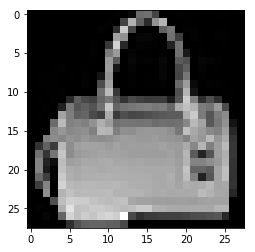

In [47]:
%matplotlib inline
from matplotlib.pylab import imshow

sample_idx = 234
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]
label_desc = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

imshow(data[:,:,0].asnumpy(), cmap='gray')
print("Data type: {}".format(data.dtype))
print("Label: {}".format(label))
print("Label description: {}".format(label_desc[label]))

## Network

In [48]:
from mxnet import gluon, autograd, ndarray

def construct_net():
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(128, activation="relu"))
        net.add(gluon.nn.Dense(64, activation="relu"))
        net.add(gluon.nn.Dense(10))
    return net

net = construct_net()
net.hybridize()

# Initialize parameters and optimizer


In [49]:

net.initialize(mx.init.Xavier(), ctx=ctx)

trainer = gluon.Trainer(net.collect_params(),
                        'sgd',
                        {'learning_rate': 0.02})

## Loss Function

In [50]:
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

## Evaluation Function

In [51]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

## Training Loop

In [52]:
num_batch = len(train_data)
epochs = 10
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        # use gluon.utils.split_load to load a slice of the mini-batch to each context
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            # pass each slice of dadata to the network's forward pass and collect output            
            outputs = [net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        # for each loss, compute gradients            
        for l in loss:
            l.backward()
        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch
    
    _, val_acc = test(net, val_data, ctx)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

[Epoch 0] Train-acc: 0.777, loss: 0.651 | Val-acc: 0.815 | time: 21.4
[Epoch 1] Train-acc: 0.838, loss: 0.457 | Val-acc: 0.839 | time: 21.4
[Epoch 2] Train-acc: 0.854, loss: 0.411 | Val-acc: 0.851 | time: 21.3
[Epoch 3] Train-acc: 0.862, loss: 0.385 | Val-acc: 0.862 | time: 21.4
[Epoch 4] Train-acc: 0.868, loss: 0.366 | Val-acc: 0.871 | time: 21.3
[Epoch 5] Train-acc: 0.874, loss: 0.349 | Val-acc: 0.872 | time: 21.4
[Epoch 6] Train-acc: 0.879, loss: 0.337 | Val-acc: 0.876 | time: 21.3
[Epoch 7] Train-acc: 0.882, loss: 0.325 | Val-acc: 0.872 | time: 21.6
[Epoch 8] Train-acc: 0.886, loss: 0.315 | Val-acc: 0.880 | time: 21.7
[Epoch 9] Train-acc: 0.889, loss: 0.306 | Val-acc: 0.881 | time: 21.4


## Training and Validataion Loss/Accuracy 

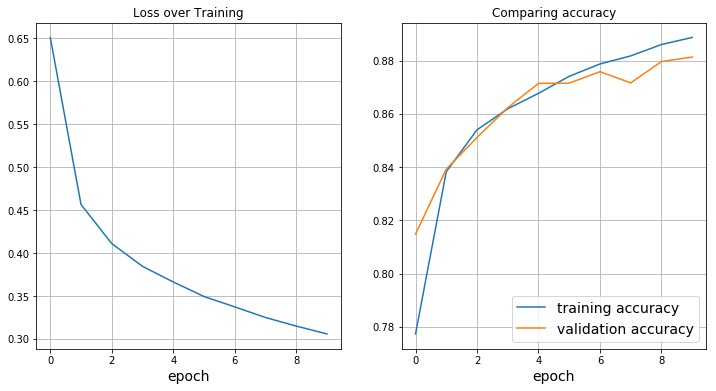

In [53]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(range(epochs), train_losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(range(epochs), train_accuracies)
p2, = fg2.plot(range(epochs), val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14) 